In [1]:

# For local testing
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
# Metrics、Plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.random.set_seed(42)
np.random.seed(42)

2025-04-17 20:54:21.142333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744937661.154253  218513 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744937661.158239  218513 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744937661.166951  218513 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744937661.166972  218513 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744937661.166974  218513 computation_placer.cc:177] computation placer alr

In [2]:
data_folder = pathlib.Path('./dataset/')

### Split train、validation、test

In [3]:
# Load training and validation datasets (split 20% from the train folder as validation set)
train_dataset = image_dataset_from_directory(
    data_folder / "train",
    color_mode='grayscale',  # Grayscale images
    image_size=(48, 48),     # FER-2013 image size
    batch_size=32,
    shuffle=True,
    label_mode='categorical',  # Multi-class labels
    validation_split=0.2,     # Split 20% as validation set
    subset="training",        # Select training subset
    seed=42                   # Set random seed for reproducibility
)

val_dataset = image_dataset_from_directory(
    data_folder / "train",
    color_mode='grayscale',
    image_size=(48, 48),
    batch_size=32,
    shuffle=True,
    label_mode='categorical',
    validation_split=0.2,     # Split 20% as validation set
    subset="validation",      # Select validation subset
    seed=42                   # Use the same random seed
)

# Load test dataset (unchanged)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    color_mode='grayscale',
    image_size=(48, 48),
    batch_size=32,
    shuffle=False,            # No need to shuffle the test set
    label_mode='categorical'
)

# Check class names
class_names = train_dataset.class_names
print("Class names:", class_names)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


I0000 00:00:1744937702.671879  218513 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.
Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Normalization and Caching

In [4]:
# Normalize image pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])
train_dataset_augmentation = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Optimize data loading
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
train_dataset_augmentation = train_dataset_augmentation.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Model 1 CNN basic 4 layer

In [5]:
# Model 1 CNN basic
inputs = keras.Input(shape=(48, 48, 1))

x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D(2)(x)
tf.keras.layers.BatchNormalization()

x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)
tf.keras.layers.BatchNormalization()

x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)
tf.keras.layers.BatchNormalization()

x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)
tf.keras.layers.BatchNormalization()

x = layers.Flatten()(x) # flatten the output
x = layers.Dense(256, activation='relu')(x) # fully connected layer
x = layers.Dropout(0.5)(x)  # prevent overfitting
outputs = layers.Dense(len(class_names), activation='softmax')(x)  # binary classification

model_basic = keras.Model(inputs, outputs)

model_basic.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_basic.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 979,719 (3.74 MB)

 Trainable params: 979,719 (3.74 MB)

 Non-trainable params: 0 (0.00 B)

#### Training

In [6]:
# callback to save the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/CNN_basic_model.keras",
        save_best_only=True,
        monitor="val_loss"),
]

# fit the model
history_basic = model_basic.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/30


I0000 00:00:1744937725.258137  219296 service.cc:152] XLA service 0x7fe79000bfb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744937725.258181  219296 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
I0000 00:00:1744937725.564661  219296 cuda_dnn.cc:529] Loaded cuDNN version 90300


 28/718 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2347 - loss: 1.8606

I0000 00:00:1744937728.646871  219296 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.2499 - loss: 1.8208 - val_accuracy: 0.2574 - val_loss: 1.7748
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2925 - loss: 1.7372 - val_accuracy: 0.4179 - val_loss: 1.5126
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4188 - loss: 1.4998 - val_accuracy: 0.4693 - val_loss: 1.3707
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4792 - loss: 1.3638 - val_accuracy: 0.5018 - val_loss: 1.2995
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5206 - loss: 1.2729 - val_accuracy: 0.5112 - val_loss: 1.2732
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5428 - loss: 1.1974 - val_accuracy: 0.5231 - val_loss: 1.2518
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5772 - loss: 1.1176 - val_accuracy: 0.5175 - val_loss: 1.2877
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6040 - loss: 1.0524 - val_accuracy: 0.5172 - va

#### Plotting

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5058 - loss: 2.8857
Test Loss: 2.9065332412719727
Test Accuracy: 0.5204792618751526
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion Matrix (Test Set):
 [[ 465    5  124   73  136  130   25]
 [  37   35   15    5   10    9    0]
 [ 186    6  361   70  145  163   93]
 [ 105    3   71 1333  131   98   33]
 [ 163    1  107  129  621  192   20]
 [ 226    6  182  128  271  408   26]
 [  49    1  124   66   43   35  513]]


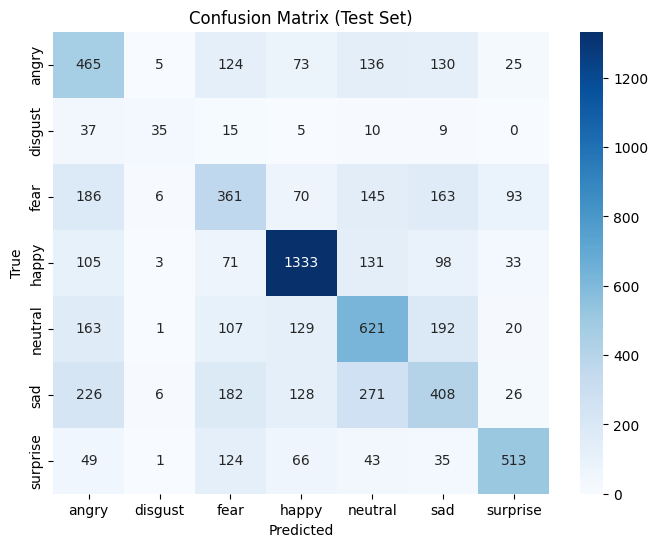

Classification Report (Test Set):
               precision    recall  f1-score   support

       angry       0.38      0.49      0.42       958
     disgust       0.61      0.32      0.42       111
        fear       0.37      0.35      0.36      1024
       happy       0.74      0.75      0.75      1774
     neutral       0.46      0.50      0.48      1233
         sad       0.39      0.33      0.36      1247
    surprise       0.72      0.62      0.67       831

    accuracy                           0.52      7178
   macro avg       0.52      0.48      0.49      7178
weighted avg       0.53      0.52      0.52      7178



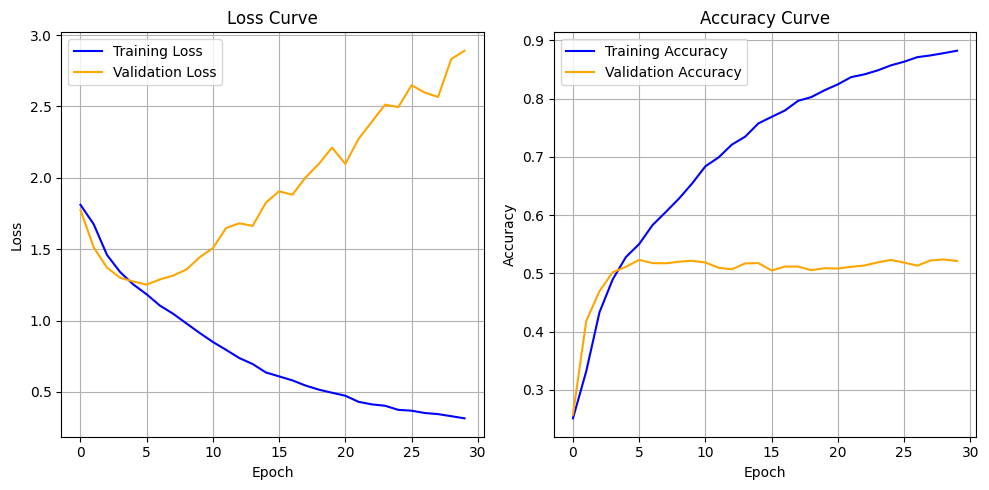

In [7]:
def plot_training_history(history, model):
    # Final evaluation: Calculate accuracy and loss on the test set
    test_loss, test_acc = model.evaluate(test_dataset)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_acc}")

    # Confusion matrix and classification report (using test_dataset)
    # Get true labels
    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    y_true = np.argmax(y_true, axis=1)

    # Predict labels
    y_pred = model.predict(test_dataset)
    y_pred = np.argmax(y_pred, axis=1)

    # Check if shapes match
    if len(y_true) != len(y_pred):
        raise ValueError(f"Mismatch between y_true ({len(y_true)}) and y_pred ({len(y_pred)}) lengths!")

    # Print confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix (Test Set):\n", cm)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Test Set)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print("Classification Report (Test Set):\n", classification_report(y_true, y_pred, target_names=class_names))

    # Plot training curves (unchanged)
    plt.figure(figsize=(10, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history_basic, model_basic)

### Model 2 + Batch Normalization and Dropout

In [8]:
# Model 2 CNN with Batch Normalization and Dropout
inputs = keras.Input(shape=(48, 48, 1))

# First block
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Second block
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Third block
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Fully connected layer
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)  # 7 classes

model_normalization = keras.Model(inputs, outputs)

model_normalization.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_normalization.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,02

 Total params: 3,510,215 (13.39 MB)

 Trainable params: 3,507,911 (13.38 MB)

 Non-trainable params: 2,304 (9.00 KB)

#### Training

In [9]:
# callback to save the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/CNN_model_with_batch_normalization.keras",
        save_best_only=True,
        monitor="val_loss"),
]

# fit the model
history_batch_normalization = model_normalization.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.2724 - loss: 2.1673 - val_accuracy: 0.4616 - val_loss: 1.4036
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4641 - loss: 1.4078 - val_accuracy: 0.4947 - val_loss: 1.3186
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5290 - loss: 1.2392 - val_accuracy: 0.3985 - val_loss: 1.6632
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.5539 - loss: 1.1802 - val_accuracy: 0.4820 - val_loss: 1.3519
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5849 - loss: 1.1053 - val_accuracy: 0.5739 - val_loss: 1.1236
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6117 - loss: 1.0319 - val_accuracy: 0.3310 - val_loss: 2.2030
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6134 - loss: 1.0318 - val_accuracy: 0.5781 - val_loss: 1.1399
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6589 - loss: 0.9230 - val_a

#### Plotting

  1/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5625 - loss: 1.8916

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5858 - loss: 2.2168
Test Loss: 2.0305328369140625
Test Accuracy: 0.6139593124389648
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Confusion Matrix (Test Set):
 [[ 541    3   79   66  117  128   24]
 [  29   58    7    3    2    9    3]
 [ 140    1  407   56  142  168  110]
 [  58    2   33 1487  104   54   36]
 [ 124    1   77   99  724  181   27]
 [ 165    1  144   92  255  564   26]
 [  31    1   72   49   34   18  626]]


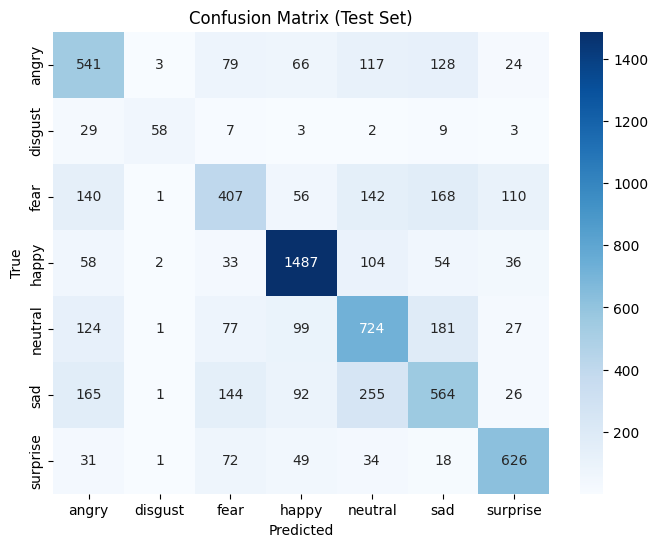

Classification Report (Test Set):
               precision    recall  f1-score   support

       angry       0.50      0.56      0.53       958
     disgust       0.87      0.52      0.65       111
        fear       0.50      0.40      0.44      1024
       happy       0.80      0.84      0.82      1774
     neutral       0.53      0.59      0.55      1233
         sad       0.50      0.45      0.48      1247
    surprise       0.73      0.75      0.74       831

    accuracy                           0.61      7178
   macro avg       0.63      0.59      0.60      7178
weighted avg       0.61      0.61      0.61      7178



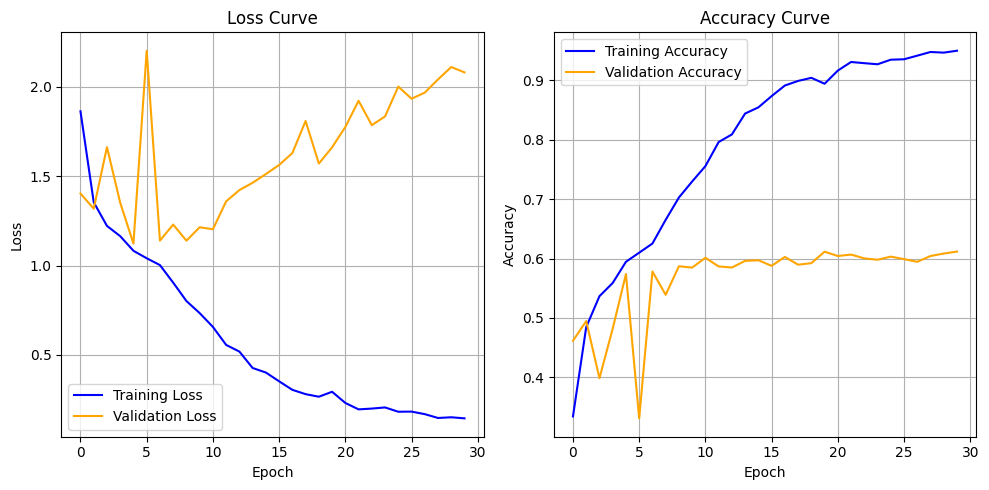

In [10]:
# Plot training history
plot_training_history(history_batch_normalization, model_normalization)

### Model 3 Batch Normalization with augmentation + SGD + ReduceLROnPlateau

In [11]:
# Model 3 Batch Normalization with augmentation + SGD
inputs = keras.Input(shape=(48, 48, 1))

# First block
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Second block
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Third block
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Fully connected layer
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)  # 7 classes

model_augmentation_normalization_SGD = keras.Model(inputs, outputs)

model_augmentation_normalization_SGD.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_augmentation_normalization_SGD.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 256)            │         1,02

 Total params: 3,510,215 (13.39 MB)

 Trainable params: 3,507,911 (13.38 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [12]:
# callback to save the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/CNN_model_augmentation_normalization_SGD.keras",
        save_best_only=True,
        monitor="val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# fit the model
history_augmentation_normalization_SGD = model_augmentation_normalization_SGD.fit(
    train_dataset_augmentation,
    epochs=30,
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.2052 - loss: 2.3179 - val_accuracy: 0.2527 - val_loss: 1.8271 - learning_rate: 0.0100
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.2352 - loss: 1.9730 - val_accuracy: 0.2923 - val_loss: 1.7828 - learning_rate: 0.0100
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.2613 - loss: 1.8638 - val_accuracy: 0.3139 - val_loss: 1.7194 - learning_rate: 0.0100
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.2906 - loss: 1.7753 - val_accuracy: 0.3400 - val_loss: 1.6359 - learning_rate: 0.0100
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3272 - loss: 1.7030 - val_accuracy: 0.3740 - val_loss: 1.5682 - learning_rate: 0.0100
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3469 - loss: 1.6462 - val_accuracy: 0.3888 - val_loss: 1.5713 - learning_rate: 0.0100
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3895 - loss:

  1/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3438 - loss: 2.4572

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5101 - loss: 1.9579
Test Loss: 1.8287335634231567
Test Accuracy: 0.5436054468154907
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Confusion Matrix (Test Set):
 [[ 445    6  141   62  144  123   37]
 [  42   19   21    9    8   11    1]
 [ 140    3  381   57  158  168  117]
 [  72    2   88 1391  108   62   51]
 [  94    4  150   97  657  178   53]
 [ 162    5  210   89  300  445   36]
 [  42    1  129   39   34   22  564]]


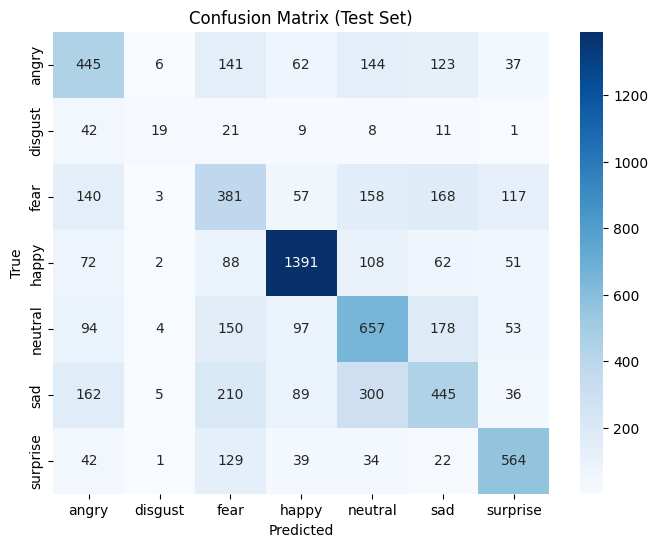

Classification Report (Test Set):
               precision    recall  f1-score   support

       angry       0.45      0.46      0.46       958
     disgust       0.47      0.17      0.25       111
        fear       0.34      0.37      0.36      1024
       happy       0.80      0.78      0.79      1774
     neutral       0.47      0.53      0.50      1233
         sad       0.44      0.36      0.39      1247
    surprise       0.66      0.68      0.67       831

    accuracy                           0.54      7178
   macro avg       0.52      0.48      0.49      7178
weighted avg       0.55      0.54      0.54      7178



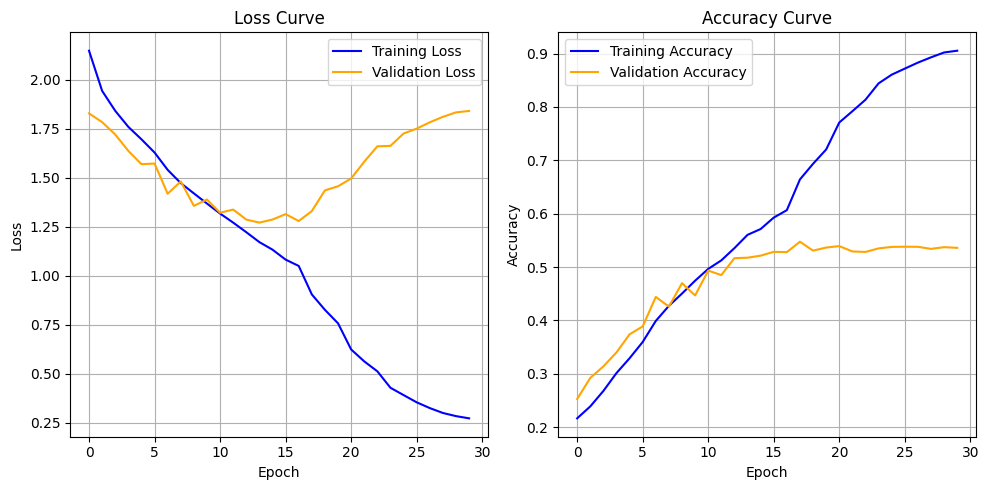

In [13]:
# Plot training history
plot_training_history(history_augmentation_normalization_SGD, model_augmentation_normalization_SGD)